# Part 3: Fine-tuning and Evaluation on CoSQA

This notebook demonstrates the complete pipeline for fine-tuning a SentenceTransformer model for **code search** using the CoSQA dataset and evaluating its performance using standard retrieval metrics.

## Overview
- **Fine-tuning**: Train a SentenceTransformer model using Multiple Negatives Ranking Loss
- **Evaluation**: Compare base model vs fine-tuned model performance
- **Metrics**: Recall@10, MRR@10, and nDCG@10


In [1]:
from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.trainer import SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from transformers import TrainerCallback
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from typing import List, Set
from search_engine import Search
from finetuning_multiple import fine_tune_cosqa
from evaluate import (
    calculate_recall_at_10,
    calculate_mrr_at_10,
    calculate_ndcg_at_10
)
from evaluate import evaluate_model

## 1️⃣ Fine-tuning Process

This section runs the fine-tuning script that:
- Loads the CoSQA dataset
- Prepares query-document triplets
- Fine-tunes using **Multiple Negatives Ranking Loss**
- Generates a training loss visualization

Corpus loaded with 20604 documents.
Queries loaded with 20604 queries.
Train 'test' split loaded with 19604 query-document pairs.
Loading model...
Model loaded.
Building corpus and query lookup maps...
Building positive (query, code) pairs...
Built 19604 training pairs.
Creating triplets...
Created 19604 sample triplets :
Created train_dataset with 19604 triplets.
MultipleNegativesRankingLoss defined.


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/Users/belalyahouni/Desktop/mon-20-oct-2025/ML-for-Context-in-AI-Assistant/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.243500
100,0.238000
150,0.243500
200,0.206500
250,0.209800
300,0.188200
350,0.170500
400,0.176200
450,0.186400
500,0.188800


Step 100: Loss = 0.2380
Step 200: Loss = 0.2065
Step 300: Loss = 0.1882
Step 400: Loss = 0.1762
Step 500: Loss = 0.1888
Step 600: Loss = 0.1589
Step 700: Loss = 0.1389
Step 800: Loss = 0.1714
Step 900: Loss = 0.1449
Step 1000: Loss = 0.1347
Step 1100: Loss = 0.1024
Step 1200: Loss = 0.1386


/Users/belalyahouni/Desktop/mon-20-oct-2025/ML-for-Context-in-AI-Assistant/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step 1300: Loss = 0.1125
Step 1400: Loss = 0.1086
Step 1500: Loss = 0.1018
Step 1600: Loss = 0.0997
Step 1700: Loss = 0.1072
Step 1800: Loss = 0.1088
Step 1900: Loss = 0.1100
Step 2000: Loss = 0.1123
Step 2100: Loss = 0.0981
Step 2200: Loss = 0.1017
Step 2300: Loss = 0.0949
Step 2400: Loss = 0.0956
Fine-tuning complete! Model saved to 'fine_tuned_model_multiple'.


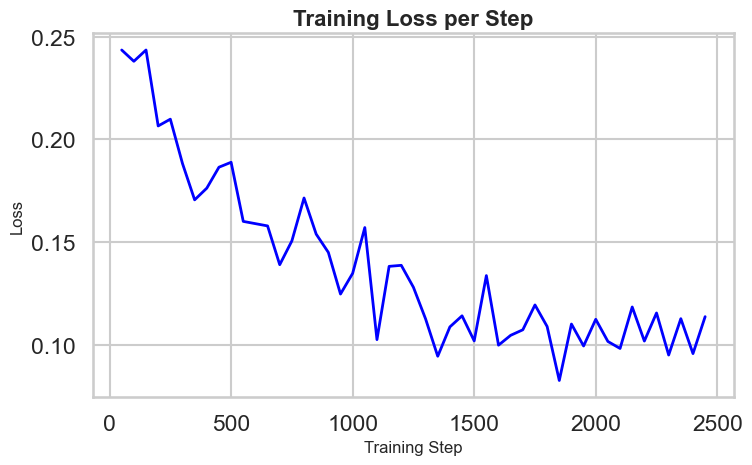

Loss curve saved to 'training_loss_multiple.png'.


In [ ]:
fine_tune_cosqa()

## 2️⃣ Model Evaluation

We evaluate both the base model and fine-tuned model using standard retrieval metrics:

- **Recall@10**: Proportion of queries where at least one relevant document appears in top 10 results
- **MRR@10**: Mean Reciprocal Rank - average rank of the first relevant document
- **nDCG@10**: Normalized Discounted Cumulative Gain - ranking quality considering all relevant documents

### Base Model Evaluation

In [2]:
# Run evaluation on original model
base_recall, base_mrr, base_ndcg = evaluate_model()

Corpus loaded with 20604 documents.
Queries loaded with 20604 queries.
Evaluation 'test' split loaded with 500 query-document pairs.
Loading all-MiniLM-L6-v2 model ...
Building the search index... (This may take a while)
Generating embeddings for 20604 documents...
Embeddings generated.
Index built. Total vectors in index: 20604
Index saved to search_index.usearch
Document map saved to documents.json

Indexing complete! Your search engine is ready.

--- Starting Search Loop for Evaluation ---
Found 500 unique queries to test.
  ...processed 50/500 queries
  ...processed 100/500 queries
  ...processed 150/500 queries
  ...processed 200/500 queries
  ...processed 250/500 queries
  ...processed 300/500 queries
  ...processed 350/500 queries
  ...processed 400/500 queries
  ...processed 450/500 queries
  ...processed 500/500 queries


✅ Evaluation complete.

--- FINAL RESULTS ---
Recall@10: 0.5660
MRR@10:    0.3554
nDCG@10:   0.4048


### Fine-tuned Model Evaluation

In [ ]:
# Run evaluation on fine-tuned model
model_name = 'fine_tuned_model_multiple/checkpoint-2452'

new_recall, new_mrr, new_ndcg = evaluate_model(model_name)

Corpus loaded with 20604 documents.
Queries loaded with 20604 queries.
Evaluation 'test' split loaded with 500 query-document pairs.
Loading fine_tuned_model_multiple/checkpoint-2452 model ...
Building the search index... (This may take a while)
Generating embeddings for 20604 documents...
Embeddings generated.
Index built. Total vectors in index: 20604
Index saved to search_index.usearch
Document map saved to documents.json

Indexing complete! Your search engine is ready.

--- Starting Search Loop for Evaluation ---
Found 500 unique queries to test.
  ...processed 50/500 queries
  ...processed 100/500 queries
  ...processed 150/500 queries
  ...processed 200/500 queries
  ...processed 250/500 queries
  ...processed 300/500 queries
  ...processed 350/500 queries
  ...processed 400/500 queries
  ...processed 450/500 queries
  ...processed 500/500 queries


✅ Evaluation complete.

--- FINAL RESULTS ---
Recall@10: 0.6420
MRR@10:    0.3764
nDCG@10:   0.4385


## 3️⃣ Results Comparison

The following cell calculates the percentage improvement of the fine-tuned model over the base model across all metrics.


In [5]:
percent_recall = round(100 * (new_recall - base_recall) / base_recall, 4)
percent_mrr = round(100 * (new_mrr - base_mrr) / base_mrr, 4)
percent_ndcg = round(100 * (new_ndcg - base_ndcg) / base_ndcg, 4)

print(f"Recall increase: {percent_recall}%")
print(f"MRR increase: {percent_mrr}%")
print(f"NDCG increase: {percent_ndcg}%")


Recall increase: 13.4276%
MRR increase: 5.8989%
NDCG increase: 8.3172%
